In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
from matplotlib import ticker as mtick

In [40]:
# plt.style.use('seaborn')
# plt.style.use('seaborn-bright')
plt.style.use('seaborn-talk')
plt.style.use('ggplot')

print()

In [41]:
plt.figure(figsize=(10,7))

<Figure size 720x504 with 0 Axes>

<Figure size 720x504 with 0 Axes>

In [42]:
f = h5py.File("rollout/fusion_sigma_final_1.h5", 'r')


In [43]:
f.keys()

<KeysViewHDF5 ['actual_states', 'force_betas', 'force_states', 'image_betas', 'image_states', 'predicted_sigmas', 'predicted_states']>

In [68]:
i=10
pred = f['predicted_states'][i] * np.array((5.72, 6.11))
actual = f['actual_states'][i] * np.array((5.72, 6.11))
sigma = f['predicted_sigmas'][i]* np.array((5.72, 6.11))
beta_force = np.clip(f['force_betas'][i] - 1,0, 1) 
beta_image = np.clip(f['image_betas'][i] -1, 0, 1)
force = f['force_states'][i]* np.array((5.72, 6.11))
image = f['image_states'][i]* np.array((5.72, 6.11))

In [93]:
def plot_fusion_traj(pred, actual, s1, s2, b1, b2, contact=160, start=0):
    timesteps = len(actual)
    print(timesteps)

    def color(i):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        return colors[i % len(colors)]

    state_dim = actual.shape[-1]
    error = []
    for j in range(state_dim):
        fig = plt.figure(figsize=(8, 6))
        axes1 = fig.add_subplot(111)

        predicted_label_arg = {}
        actual_label_arg = {}

        predicted_label_arg['label'] = "Predicted"
        actual_label_arg['label'] = "Ground Truth"
        
        axes1.plot(range(timesteps-start),
                s1[start:, j],
                label="force",
                   c=color(3)
                )
        axes1.plot(range(timesteps-start),
                s2[start:, j], label="image", c=color(4))
                
        axes1.plot(range(timesteps-start),
                 pred[start:, j],
                     c=color(0),
                 **predicted_label_arg)
        axes1.plot(range(timesteps-start),
                 actual[start:, j],
                     c=color(1),
                 **actual_label_arg)


        axes2 = axes1.twinx()
        axes2.plot(range(timesteps-start),
                b1[start:, j], label="force beta", alpha=0.5, c=color(3)
                )
        axes2.plot(range(timesteps-start),
                b2[start:, j], label="image beta", alpha=0.5, c=color(4))  
#             conf_min = pred[start:, j] - sigma[start:, j, j] *0.5
#             conf_max = pred[start:, j] + sigma[start:, j, j] *0.5
#             plt.fill_between(range(timesteps-start), 
#                              conf_min, conf_max, 
#                              alpha=0.5)
        axes2.axvspan(contact, timesteps, alpha=0.25, color=color(2))
        axes2.axvline(contact, color=color(2))
        axes2.axvline(timesteps, color=color(2))
        
        rmse = np.sqrt(np.mean(
        (pred[start:, j] - actual[start:, j]) ** 2))
        error.append(rmse)

#         plt.title(f"State #{j} ")
        axes1.set_xlabel("Timesteps")
        axes1.set_ylabel("Object Location ")
        axes2.set_ylabel("Beta")
        axes2.set_ylim(0, 1.0)
        axes1.set_ylim(-10,10)
        axes2.set_xlim(0, timesteps+20)
        
        axes1.yaxis.set_major_locator(mtick.LinearLocator(5))
        axes2.yaxis.set_major_locator(mtick.LinearLocator(5))
        plt.grid(b=False)
        axes2.legend(ncol=2, bbox_to_anchor=(1.0, -0.20))
        axes1.legend(ncol=2, bbox_to_anchor=(0.5, -0.20))

#         axes1.legend()
        plt.show()

    return error

240


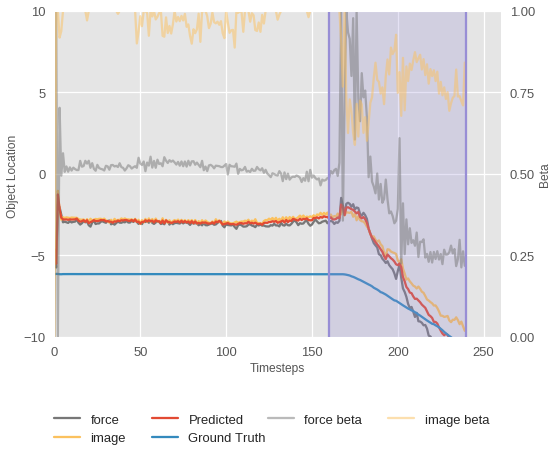

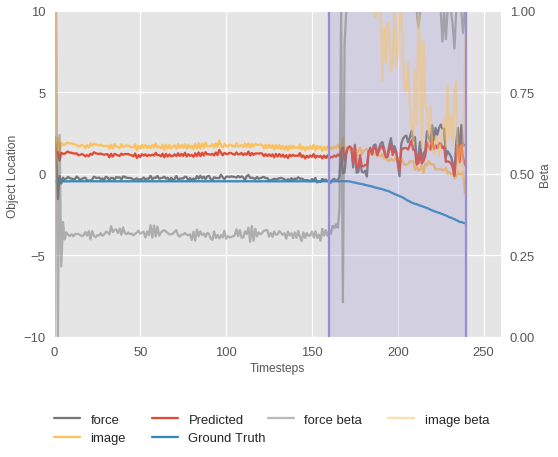

[3.004910538240908, 2.11865985975804]


In [94]:
error = plot_fusion_traj(pred, actual, force, image, beta_force, beta_image)
print(error)

In [157]:
def plot_fusion_traj2(pred, actual, s1, s2, b1, b2, contact=160, start=100):
    timesteps = len(actual)
    print(timesteps)

    def color(i):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        return colors[i % len(colors)]

    state_dim = actual.shape[-1]
    error = []
    for j in range(state_dim):
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.15})
#         fig = plt.figure(figsize=(8, 6), subplots=True)
        axes1 = axs[1]
#         axes1 = fig.add_subplot(212)

        predicted_label_arg = {}
        actual_label_arg = {}

        predicted_label_arg['label'] = "Fusion Predicted States"
        actual_label_arg['label'] = "Ground Truth"
        
        axes1.plot(range(timesteps-start),
                s1[start:, j],
                label="force filter states",
                   c=color(3)
                )
        axes1.plot(range(timesteps-start),
                s2[start:, j], label="image filter states", c=color(4))
                
        axes1.plot(range(timesteps-start),
                 pred[start:, j],
                     c=color(0),
                 **predicted_label_arg)
        axes1.plot(range(timesteps-start),
                 actual[start:, j],
                     c=color(1),
                 **actual_label_arg)

        axes2 = axs[0]
#         axes2 = fig.add_subplot(211)
        axes2.plot(range(timesteps-start),
                b1[start:, j], label="force beta", alpha=0.5, c=color(3)
                )
        axes2.plot(range(timesteps-start),
                b2[start:, j], label="image beta", alpha=0.5, c=color(4))  
#             conf_min = pred[start:, j] - sigma[start:, j, j] *0.5
#             conf_max = pred[start:, j] + sigma[start:, j, j] *0.5
#             plt.fill_between(range(timesteps-start), 
#                              conf_min, conf_max, 
#                              alpha=0.5)
        axes2.axvspan(contact-start, timesteps-start, alpha=0.25, color=color(2))
        axes1.axvspan(contact-start, timesteps-start, alpha=0.25, color=color(2))

#         axes2.axvline(contact, color=color(2))
#         axes2.axvline(timesteps, color=color(2))
        
        rmse = np.sqrt(np.mean(
        (pred[start:, j] - actual[start:, j]) ** 2))
        error.append(rmse)

#         plt.title(f"State #{j} ")
        axes1.set_xlabel("Timesteps")
        axes1.set_ylabel("Object Location ")
        axes2.set_ylabel("Beta")
        axes2.set_ylim(0, 1.5)
        axes1.set_ylim(-15,10)
#         axes2.xaxis.label.set_visible(False)
#         axes2.set_xticklabels([])
        
        
        axes1.yaxis.set_major_locator(mtick.LinearLocator(5))
        axes2.yaxis.set_major_locator(mtick.LinearLocator(5))
#         plt.grid(b=False)
#         axes2.legend(ncol=2, bbox_to_anchor=(1.0, -1.80))
#         axes1.legend(ncol=2, bbox_to_anchor=(0.5, -0.20))
        axes1.legend()
        axes2.legend()
        plt.show()

    return error

240


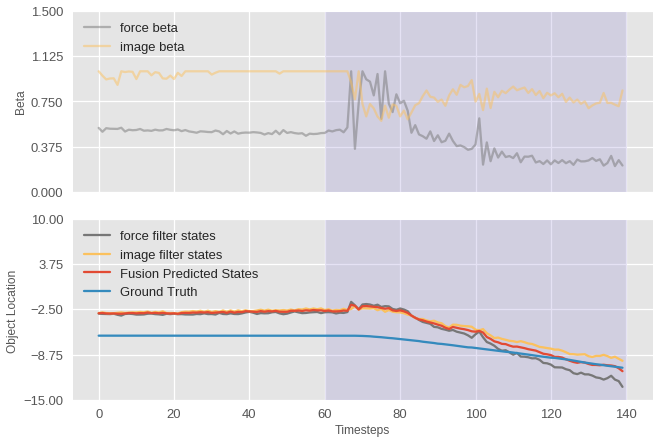

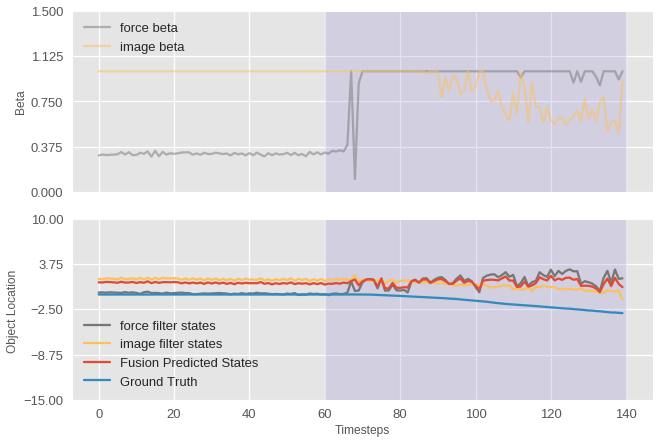

[2.8313015627223264, 2.395599514597463]


In [158]:
error = plot_fusion_traj2(pred, actual, force, image, beta_force, beta_image)
print(error)

In [96]:
def plot_kf_traj(pred, actual, sigma, plot=False, plot_traj=None, start=0):

    if plot:
        timesteps = len(actual)
        print(timesteps)

        def color(i):
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
            return colors[i % len(colors)]

        state_dim = actual.shape[-1]
        for j in range(state_dim):
            plt.figure(figsize=(8, 6))
          

            predicted_label_arg = {}
            actual_label_arg = {}

            predicted_label_arg['label'] = "Predicted"
            actual_label_arg['label'] = "Ground Truth"
            plt.plot(range(timesteps-start),
                     pred[start:, j],
#                      c=color(0),
                     **predicted_label_arg)
            plt.plot(range(timesteps-start),
                     actual[start:, j],
#                      c=color(1),
                     **actual_label_arg)
            
            conf_min = pred[start:, j] - sigma[start:, j, j] *0.5
            conf_max = pred[start:, j] + sigma[start:, j, j] *0.5
            plt.fill_between(range(timesteps-start), 
                             conf_min, conf_max, 
                             alpha=0.5)
            
            rmse = np.sqrt(np.mean(
            (pred[start:, j] - actual[start:, j]) ** 2))

            plt.title(f"State #{j} ")
            plt.xlabel("Timesteps")
            plt.ylabel("Value")
            plt.legend()
            plt.ylim(-2, 2)
            plt.show()


240


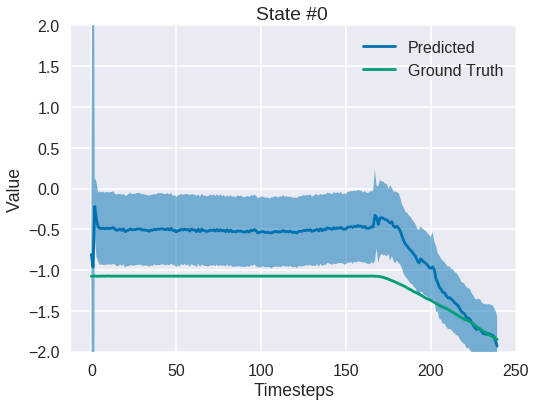

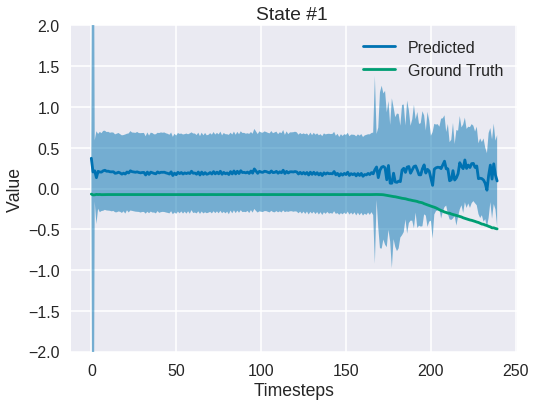

In [21]:
plot_kf_traj(pred, actual, sigma, plot=True)